## Packages importing

In [ ]:
# Packages for EDA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from datasist.structdata import detect_outliers
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import category_encoders as ce
import re

# Modeling and evaluation
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import joblib

# Packages options
sns.set(rc={'figure.figsize': [14, 7]}, font_scale=1.2) # Standard figure size for all
np.seterr(divide='ignore', invalid='ignore', over='ignore') ;

import warnings
warnings.filterwarnings("ignore")

## Reading Data

In [ ]:
df = pd.read_csv("./train.csv",low_memory=False)

#### removing unuseful Columns (Uniques)

In [ ]:
del df['ID'] # Identification
del df['Name'] # Name of client
del df['SSN'] # SSN (social security number of a person)

#### Fix Numerical Columns

1. replace _  
2. convert into float

In [ ]:
N_to_fix = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Amount_invested_monthly', 'Outstanding_Debt' , 'Monthly_Balance']

In [ ]:
def fix_nums(num):
    try :
        return float(num.replace("_",""))
    except :
        return np.nan

In [ ]:
for col in N_to_fix :
    df[col] = df[col].apply(fix_nums)

### Type_of_Loan

In [ ]:
## Rebuild Type of loans Columns
for i in df['Type_of_Loan'].value_counts().head(9).index[1:] :
    df[i] = df['Type_of_Loan'].str.contains(i)

del df['Type_of_Loan']

#### Num_Bank_Accounts

In [ ]:
df['Num_Bank_Accounts'] = df['Num_Bank_Accounts'].apply(lambda x :abs (x))

#### Num_Credit_Card

In [ ]:
df['Num_Credit_Card'].replace(0,1,inplace=True)

#### Credit_History_Age

In [ ]:
def History_age(age):
    try :
        years = int("".join(re.findall('[0-9]',''.join(age.split("and")[0]))))
        month = int("".join(re.findall('[0-9]',''.join(age.split("and")[1]))))
        return years*12 + month
    except :
        return np.nan

In [ ]:
df['Credit_History_Age'] = df['Credit_History_Age'].apply(History_age)

#### Payment_of_Min_Amount

In [ ]:
df['Payment_of_Min_Amount'].replace("NM","No",inplace=True)

In [ ]:
df['Payment_of_Min_Amount'].value_counts()

Yes    52326
No     47674
Name: Payment_of_Min_Amount, dtype: int64

#### Payment_Behaviour

In [ ]:
df['Payment_Behaviour']= df['Payment_Behaviour'].replace("!@9#%8",np.nan)

In [ ]:
df['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
Name: Payment_Behaviour, dtype: int64

### Occupation

In [ ]:
df['Occupation'].value_counts()

_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: Occupation, dtype: int64

In [ ]:
occs = df['Occupation'].value_counts().index[1:]
occs

Index(['Lawyer', 'Architect', 'Engineer', 'Scientist', 'Mechanic',
       'Accountant', 'Developer', 'Media_Manager', 'Teacher', 'Entrepreneur',
       'Doctor', 'Journalist', 'Manager', 'Musician', 'Writer'],
      dtype='object')

In [ ]:
id_ = "CUS_0xb891"
oc = df[df['Customer_ID'] == id_]['Occupation'].mode()[0]
df[df['Customer_ID'] == id_].replace("_______",oc)

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Monthly_Balance,Credit_Score,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
24,CUS_0xb891,January,54.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,433.604773,Standard,False,False,False,False,False,False,False,False
25,CUS_0xb891,February,54.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,409.951812,Standard,False,False,False,False,False,False,False,False
26,CUS_0xb891,March,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,411.427123,Standard,False,False,False,False,False,False,False,False
27,CUS_0xb891,April,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,262.499594,Standard,False,False,False,False,False,False,False,False
28,CUS_0xb891,May,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,359.374916,Standard,False,False,False,False,False,False,False,False
29,CUS_0xb891,June,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,419.880784,Standard,False,False,False,False,False,False,False,False
30,CUS_0xb891,July,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,443.549957,Standard,False,False,False,False,False,False,False,False
31,CUS_0xb891,August,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,-100.0,...,379.216381,Standard,False,False,False,False,False,False,False,False


In [ ]:
for ID in df[df['Occupation'] == "_______"]['Customer_ID'] :
    oc = df[df['Customer_ID'] == ID]['Occupation'].mode()[0]
    df[df['Customer_ID'] == ID] = df[df['Customer_ID'] == ID].replace("_______",oc)

In [ ]:
df['Occupation'].value_counts()

Lawyer           7096
Engineer         6864
Architect        6824
Mechanic         6776
Scientist        6744
Accountant       6744
Developer        6720
Media_Manager    6715
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
_______             5
Name: Occupation, dtype: int64

In [ ]:
df['Occupation'] = df['Occupation'].replace("_______",df['Occupation'].mode()[0])

In [ ]:
df['Occupation'].value_counts()

Lawyer           7101
Engineer         6864
Architect        6824
Mechanic         6776
Scientist        6744
Accountant       6744
Developer        6720
Media_Manager    6715
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
Name: Occupation, dtype: int64

#### Credit_Mix

In [ ]:
df['Credit_Mix'].value_counts()

Standard    36479
Good        24337
_           20195
Bad         18989
Name: Credit_Mix, dtype: int64

In [ ]:
m = {
    "Bad":0,
    "Standard":1,
    "Good":2,
    "_":np.nan
}

In [ ]:
df['Credit_Mix'] = df['Credit_Mix'].map(m)

### Advanced Handling Missing Data

In [ ]:
# Edit Columns from bool to int
for col in list(df.columns[-8:]):
    df[col] = df[col].astype(float)

In [ ]:
IDs = 1
for ID in df['Customer_ID'].unique() :
    df['Customer_ID'] = df['Customer_ID'].replace(ID,IDs)
    IDs += 1

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)

In [ ]:
Numericals = df.select_dtypes(exclude='object').columns[1:]
Numericals

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance', 'Credit-Builder Loan',
       'Personal Loan', 'Debt Consolidation Loan', 'Student Loan',
       'Payday Loan', 'Mortgage Loan', 'Auto Loan', 'Home Equity Loan'],
      dtype='object')

In [ ]:
for col in Numericals[1:]:
    imputer.fit(df[['Customer_ID',col]])
    df[['Customer_ID',col]] = imputer.transform(df[['Customer_ID',col]])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  float64
 1   Month                     100000 non-null  object 
 2   Age                       100000 non-null  float64
 3   Occupation                100000 non-null  object 
 4   Annual_Income             100000 non-null  float64
 5   Monthly_Inhand_Salary     100000 non-null  float64
 6   Num_Bank_Accounts         100000 non-null  float64
 7   Num_Credit_Card           100000 non-null  float64
 8   Interest_Rate             100000 non-null  float64
 9   Num_of_Loan               100000 non-null  float64
 10  Delay_from_due_date       100000 non-null  float64
 11  Num_of_Delayed_Payment    100000 non-null  float64
 12  Changed_Credit_Limit      100000 non-null  float64
 13  Num_Credit_Inquiries      100000 non-null  fl

In [ ]:
imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(df[['Payment_Behaviour']])
df[['Payment_Behaviour']] = imputer.transform(df[['Payment_Behaviour']])

### Handling Outliers

In [ ]:
## replace Outliers with median
for col in Numericals :
    outliers_indecies = detect_outliers(df,0,[col])
    median = df[col].median()
    df[col].iloc[outliers_indecies] = median

# Data Preprocessing

### Handling Catogerical

In [ ]:
df.select_dtypes(include="object")

,Month,Occupation,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score
0,January,Scientist,No,High_spent_Small_value_payments,Good
1,February,Scientist,No,Low_spent_Large_value_payments,Good
2,March,Scientist,No,Low_spent_Medium_value_payments,Good
3,April,Scientist,No,Low_spent_Small_value_payments,Good
4,May,Scientist,No,High_spent_Medium_value_payments,Good
...,...,...,...,...,...
99995,April,Mechanic,No,High_spent_Large_value_payments,Poor
99996,May,Mechanic,No,High_spent_Medium_value_payments,Poor
99997,June,Mechanic,No,High_spent_Large_value_payments,Poor
99998,July,Mechanic,No,Low_spent_Large_value_payments,Standard


In [ ]:
df['Credit_Score'].value_counts()

Standard    53174
Poor        28998
Good        17828
Name: Credit_Score, dtype: int64

In [ ]:
m = {
    "Poor":0,
    "Standard":1,
    "Good":2
}

In [ ]:
df['Credit_Score'] = df['Credit_Score'].map(m)

In [ ]:
del df['Customer_ID']

In [ ]:
df = pd.get_dummies(df,drop_first=True)

In [1]:
df.info()

NameError: name 'df' is not defined

In [ ]:
df.to_csv("Preprocessed_Data.csv")

In [ ]:
df = pd.read_csv("./Preprocessed_Data_train.csv",low_memory=False)

In [ ]:
df.sample(10)

,Unnamed: 0,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
77776,77776,47.0,103838.720,8605.226667,7.0,3.0,8.0,1.0,18.0,11.0,...,0,0,0,0,1,1,0,0,0,0
68840,68840,15.0,81475.280,6865.606667,6.0,3.0,17.0,0.0,24.0,19.0,...,0,0,1,0,1,0,0,0,1,0
76167,76167,38.0,12821.555,932.462917,4.0,7.0,16.0,4.0,27.0,22.0,...,1,0,0,0,1,0,0,0,0,1
15954,15954,21.0,50774.910,4431.242500,6.0,7.0,23.0,7.0,18.0,20.0,...,0,0,0,0,1,0,0,0,0,0
60709,60709,42.0,82928.040,7117.670000,7.0,4.0,16.0,3.0,21.0,10.0,...,0,0,0,0,1,0,0,0,1,0
19921,19921,26.0,8928.690,601.057500,9.0,10.0,16.0,5.0,18.0,13.0,...,0,1,0,0,1,0,0,0,0,1
1681,1681,26.0,96582.240,7886.520000,3.0,3.0,13.0,1.0,6.0,18.0,...,0,0,1,0,0,0,1,0,0,0
51661,51661,42.0,35758.390,3212.865833,3.0,3.0,15.0,3.0,31.0,17.0,...,0,0,0,0,1,1,0,0,0,0
34495,34495,22.0,20574.710,1813.559167,7.0,9.0,25.0,6.0,21.0,22.0,...,0,0,0,0,1,0,1,0,0,0
71557,71557,32.0,108223.710,7841.023964,1.0,7.0,2.0,1.0,5.0,10.0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
new_df = df[best_features_fscore.tolist()+["Credit_Score"]]

In [ ]:
new_df

,Credit_Mix,Interest_Rate,Occupation_Writer,Num_Credit_Inquiries,Delay_from_due_date,Num_Bank_Accounts,Credit_History_Age,Num_Credit_Card,Num_of_Delayed_Payment,Outstanding_Debt,Credit_Score
0,2.0,3.0,0,4.0,3.0,3.0,265.0,4.0,7.0,809.98,2
1,2.0,3.0,0,4.0,-1.0,3.0,265.0,4.0,7.0,809.98,2
2,2.0,3.0,0,4.0,3.0,3.0,267.0,4.0,7.0,809.98,2
3,2.0,3.0,0,4.0,5.0,3.0,268.0,4.0,4.0,809.98,2
4,2.0,3.0,0,4.0,6.0,3.0,269.0,4.0,7.0,809.98,2
...,...,...,...,...,...,...,...,...,...,...,...
99995,2.0,7.0,0,3.0,23.0,4.0,378.0,6.0,7.0,502.38,0
99996,2.0,7.0,0,3.0,18.0,4.0,379.0,6.0,7.0,502.38,0
99997,2.0,13.0,0,3.0,27.0,4.0,380.0,6.0,6.0,502.38,0
99998,2.0,7.0,0,3.0,20.0,4.0,381.0,6.0,6.0,502.38,1


### Data Spliting
- Try Resampling

In [ ]:
# define dataset
X, y = new_df.drop("Credit_Score",axis=1).values , df["Credit_Score"]

## Apply oversampling
- Data is Not 100% balanced, Let's try improving it.

In [ ]:
y.value_counts(normalize=True)

1    0.53174
0    0.28998
2    0.17828
Name: Credit_Score, dtype: float64

In [ ]:
from imblearn.over_sampling import SMOTE
rus = SMOTE(sampling_strategy='auto')
X_data_rus, y_data_rus = rus.fit_resample(X, y)

In [ ]:
y_data_rus.value_counts(normalize=True)

2    0.333333
1    0.333333
0    0.333333
Name: Credit_Score, dtype: float64

In [ ]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data_rus, y_data_rus, test_size=0.3, random_state=42,stratify=y_data_rus)

### Handling Numerical
- Using Power transformer to avoid Data Skewness

In [ ]:
scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)

In [ ]:
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

# Modeling and Evaluation


#### Model Building

In [ ]:
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=10, n_jobs=-1)
randomForest = RandomForestClassifier(n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)

model = StackingClassifier([
    ('bagging', bagging),
    ('extraTress', extraTrees),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('XGB', XGB)
], n_jobs=-1)

#### Model fitting

In [ ]:
model.fit(X_train, y_train)

[13:39:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=10, n_jobs=-1)),
                               ('randomforest',
                                RandomForestClassifier(n_jobs=-1)),
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytr...
                                              interaction_constraints=None,
                                              learning_rate=None,
                                              max_delta_step=None,
                                              max_depth=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None,
                                              reg_alpha=None, reg_lambda=None,
                                              scale_pos_weight=None,
                                              subsample=None, tree_method=None,
                                              validate_parameters=None,
                                              verbosity=None))],
                   n_jobs=-1)

#### model evaluation

In [ ]:
print("Train Score: ",model.score(X_train, y_train))

/usr/local/lib/python3.8/dist-packages/cudf/utils/gpu_utils.py:142: UserWarning: No NVIDIA GPU detected
  warnings.warn("No NVIDIA GPU detected")
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/cudf/utils/gpu_utils.py:142: UserWarning: No NVIDIA GPU detected
  warnings.warn("No NVIDIA GPU detected")
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False whe

[13:39:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Score:  0.999131330318363


In [ ]:
print("Test Score: ",model.score(X_test, y_test))

Test Score:  0.8518085128612324


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86     15525
           1       0.81      0.79      0.80     16267
           2       0.90      0.89      0.90     16065

    accuracy                           0.85     47857
   macro avg       0.85      0.85      0.85     47857
weighted avg       0.85      0.85      0.85     47857



#### model Saving

In [ ]:
# joblib.dump(model,'model.h5')
# joblib.dump(scalar,'scalar.h5')

In [ ]:
model = RandomForestClassifier(random_state=1)


In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
cv = cross_validate(model, X_train, y_train, cv=5)

In [ ]:
cv

{'fit_time': array([17.83295417, 17.8890276 , 17.93701029, 17.8236897 , 18.19042182]),
 'score_time': array([0.32012701, 0.3191936 , 0.32034349, 0.31868505, 0.31586862]),
 'test_score': array([0.82998254, 0.83092285, 0.82420633, 0.82837057, 0.83141539])}

In [ ]:
print(cv["test_score"].mean())

0.828979537008015


In [ ]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 14:47:31


22:46

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     15713
           1       0.74      0.83      0.78     14343
           2       0.92      0.82      0.87     17801

    accuracy                           0.83     47857
   macro avg       0.83      0.83      0.83     47857
weighted avg       0.84      0.83      0.84     47857



In [ ]:
print("Train Score: ",model.score(X_train, y_train))

Train Score:  1.0


In [ ]:
print("Test Score: ",model.score(X_test, y_test))

Test Score:  0.8341099525670226


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.85693375, 0.82618699, 0.82034717]),
 array([0.84409478, 0.74285356, 0.91537642]),
 array([0.85046581, 0.78230731, 0.86526041]),
 array([15952, 15952, 15953]))

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_pred)

0.8341099525670226

In [ ]:
cv3 = cross_validate(model, X_train, y_train, cv=3)
cv3

{'fit_time': array([14.84248805, 14.97179127, 14.85054493]),
 'score_time': array([0.49466944, 0.49381566, 0.49684   ]),
 'test_score': array([0.82204073, 0.82295417, 0.82262701])}

In [ ]:
cv1 = cross_validate(model, X_train, y_train, cv=2)
cv1

{'fit_time': array([10.59227729, 10.73417068]),
 'score_time': array([0.68807745, 0.68760467]),
 'test_score': array([0.81731234, 0.81623442])}

In [ ]:
print("HI")

HI


In [ ]:
from sklearn.model_selection import KFold

In [ ]:
def get_eval(model,x_test,y_test):
    score, acc = model.evaluate(x_test, y_test)
    print(f'loss={score}, accuracy={acc}')
    return f'{score},{acc}\n'

In [ ]:
def k_flod_cross_val(model,x_train, K_Fold = 5):
    L = []
    kfold = KFold(n_splits = K_Fold, shuffle = True, random_state = 2)
    for train_index, test_index in kfold.split(x_train):
        # 取得訓練和測試數據
        X_train, X_test = x_train[train_index], x_train[test_index]
        Y_train, Y_test = y_train[train_index], y_train[test_index]
        # 重新建模
        # 在測試數據上評估模型
        history=model.fit(
            X_train,
            Y_train,
        )
        result = get_eval(model,X_test,Y_test)
        L.append(result)
    return L

In [ ]:
Train_pred = model.predict(X_train)

In [ ]:
accuracy_score(y_train, Train_pred)

1.0

In [ ]:
print("Train Score: ",model.score(X_train, y_train))

In [ ]:
def test_model(model):
    cv = cross_validate(model, X_train, y_train, cv=5)
    k_flod_acc = cv["test_score"].mean()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Train Score: ",model.score(X_train, y_train))
    print("Test Score: ",model.score(X_test, y_test))

In [ ]:
len(y_train)

111665

In [ ]:
cv10 = cross_validate(model, X_train, y_train,scoring=("accuracy"), cv=10)
cv10

{'fit_time': array([20.86730671, 20.96021461, 20.95510817, 21.01405692, 20.86253214,
        20.82434964, 21.03036427, 20.83088994, 20.85994554, 20.888484  ]),
 'score_time': array([0.17853761, 0.17907953, 0.17906499, 0.17951608, 0.17819619,
        0.17897344, 0.17906642, 0.17888331, 0.1785605 , 0.17857051]),
 'test_score': array([0.82833348, 0.83030357, 0.83209456, 0.83728844, 0.82654249,
        0.8317213 , 0.83154218, 0.83082572, 0.83539316, 0.83449758])}

In [ ]:
def test_model(model):
#     cv = cross_validate(model, X_train, y_train, cv=5)
#     k_flod_acc = cv["test_score"].mean()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Train Score: ",model.score(X_train, y_train))
    print("Test Score: ",model.score(X_test, y_test))

In [ ]:
from sklearn.linear_model import LogisticRegression
test_model(LogisticRegression())

Train Score:  0.7205749339542381
Test Score:  0.7151931796811334


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
test_model(KNeighborsClassifier())

Train Score:  0.8954909774772758
Test Score:  0.8244352968217815


In [ ]:
from sklearn.tree  import DecisionTreeClassifier
test_model(DecisionTreeClassifier())

Train Score:  1.0
Test Score:  0.742629082474873


In [ ]:
from sklearn.ensemble import RandomForestClassifier
test_model(RandomForestClassifier())

Train Score:  1.0
Test Score:  0.8339427878889191


In [ ]:
from xgboost import XGBClassifier
test_model(XGBClassifier())

[15:43:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Score:  0.8755294855147092
Test Score:  0.8366592139081013


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
test_model(AdaBoostClassifier())

Train Score:  0.7336676666815922
Test Score:  0.7332678605010762


In [ ]:
from sklearn.svm import SVC
test_model(SVC(kernel= 'rbf', random_state=1, C=0.1))

Train Score:  0.743240943894685
Test Score:  0.7361514511983618


In [ ]:
X_train.shape

(111665, 54)

# FS

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import feature_selection as fs
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import io
import requests

import tensorflow as tf
import csv
import pandas as pd
import numpy as np
import os
import math
from sklearn import metrics
from sklearn.metrics import roc_curve
from tensorflow.keras import Model, layers
import argparse


2023-01-02 15:52:35.219393: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
Data = preprocessing.MinMaxScaler().fit_transform(X_train)
target = preprocessing.LabelEncoder().fit_transform(y_train)

In [ ]:
clf = DecisionTreeClassifier(random_state=999)

In [ ]:
cv_method = RepeatedStratifiedKFold(n_splits=5,
                                     n_repeats=3,
                                     random_state=999)

In [ ]:
scoring_metric = 'accuracy'

In [ ]:
cv_results_full = cross_val_score(estimator=clf,
                             X=Data,
                             y=target,
                             cv=cv_method,
                             scoring=scoring_metric)

In [ ]:
cv_results_full

array([0.73510052, 0.73416021, 0.73335423, 0.74038418, 0.74038418,
       0.74060807, 0.7363095 , 0.74302602, 0.73859311, 0.73680204,
       0.73501097, 0.74168271, 0.7320557 , 0.73675727, 0.73657816])

In [ ]:
num_features = 20
fs_fit_fscore = fs.SelectKBest(fs.f_classif, k=num_features)
fs_fit_fscore.fit_transform(Data, target)
fs_indices_fscore = np.argsort(np.nan_to_num(fs_fit_fscore.scores_))[::-1][0:num_features]
fs_indices_fscore

array([12,  6, 48, 11,  8,  4, 15,  5,  9, 13,  7, 10,  2,  3, 18,  1, 16,
       25, 20, 21])

In [ ]:
best_features_fscore = df.columns[fs_indices_fscore].values
best_features_fscore

array(['Credit_Mix', 'Interest_Rate', 'Occupation_Writer',
       'Num_Credit_Inquiries', 'Delay_from_due_date', 'Num_Bank_Accounts',
       'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Delayed_Payment',
       'Outstanding_Debt', 'Num_of_Loan', 'Changed_Credit_Limit',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Monthly_Balance', 'Age',
       'Total_EMI_per_month', 'Mortgage Loan', 'Credit-Builder Loan',
       'Personal Loan'], dtype=object)

In [ ]:
feature_importances_fscore = fs_fit_fscore.scores_[fs_indices_fscore]
feature_importances_fscore

array([37107.0448935 , 25480.44738959, 22704.47722589, 18992.43831946,
       18902.48359943, 16851.00745896, 16690.99385936, 16526.64564289,
       16023.12793835, 15818.04395276, 11607.13910024,  4804.27077918,
        3351.67136587,  3210.63347158,  2641.83104634,  2250.82796783,
        1063.90932762,   999.90352093,   983.61554914,   894.75236542])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# plt.rcParams["figure.figsize"] = (20,3)
figure(figsize=(80, 60), dpi=160)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# fig.set_size_inches(18.5, 10.5)
def plot_imp(best_features, scores, method_name):
    plt.rcParams['figure.figsize'] = [16, 12]
    plt.barh(best_features, scores)
    plt.title(method_name + ' Feature Importances')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()
    plt.savefig('plot.png')

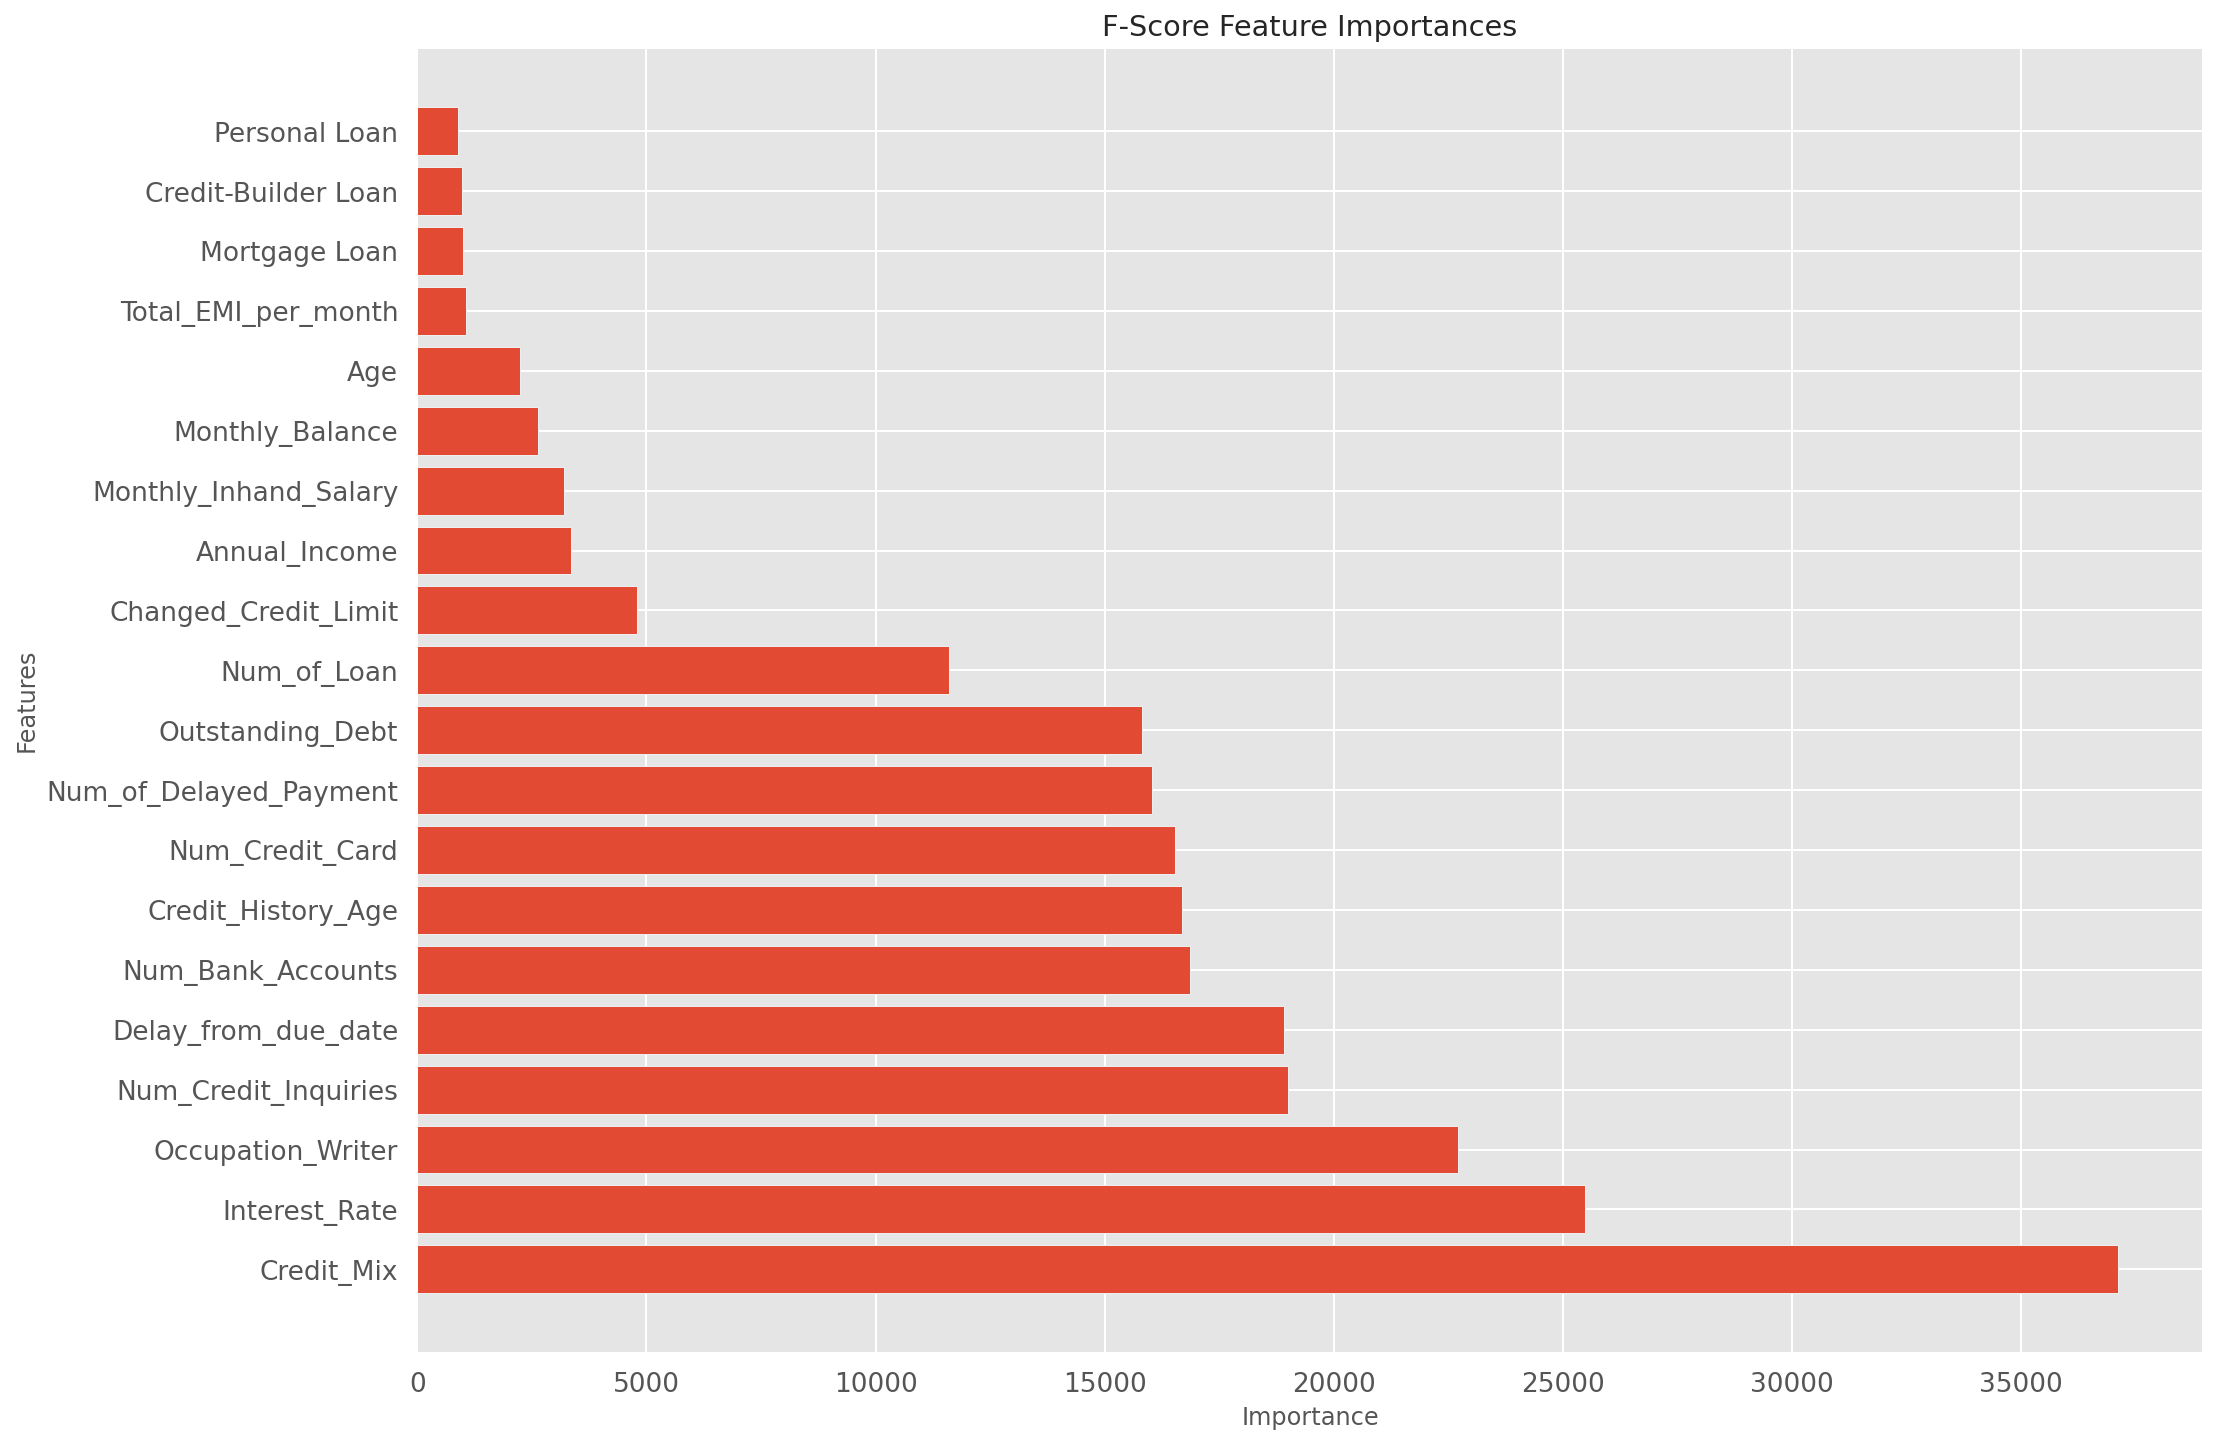

<Figure size 1152x864 with 0 Axes>

In [ ]:
plot_imp(best_features_fscore, feature_importances_fscore, 'F-Score')

In [ ]:
df[best_features_fscore[:10]]

,Credit_Mix,Interest_Rate,Occupation_Writer,Num_Credit_Inquiries,Delay_from_due_date,Num_Bank_Accounts,Credit_History_Age,Num_Credit_Card,Num_of_Delayed_Payment,Outstanding_Debt
0,2.0,3.0,0,4.0,3.0,3.0,265.0,4.0,7.0,809.98
1,2.0,3.0,0,4.0,-1.0,3.0,265.0,4.0,7.0,809.98
2,2.0,3.0,0,4.0,3.0,3.0,267.0,4.0,7.0,809.98
3,2.0,3.0,0,4.0,5.0,3.0,268.0,4.0,4.0,809.98
4,2.0,3.0,0,4.0,6.0,3.0,269.0,4.0,7.0,809.98
...,...,...,...,...,...,...,...,...,...,...
99995,2.0,7.0,0,3.0,23.0,4.0,378.0,6.0,7.0,502.38
99996,2.0,7.0,0,3.0,18.0,4.0,379.0,6.0,7.0,502.38
99997,2.0,13.0,0,3.0,27.0,4.0,380.0,6.0,6.0,502.38
99998,2.0,7.0,0,3.0,20.0,4.0,381.0,6.0,6.0,502.38


In [ ]:
X_train = df[best_features_fscore[:10]]

In [ ]:
def test_model(model):
#     cv = cross_validate(model, X_train, y_train, cv=5)
#     k_flod_acc = cv["test_score"].mean()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Train Score: ",model.score(X_train, y_train))
    print("Test Score: ",model.score(X_test, y_test))

In [ ]:
test_model(LogisticRegression())

Train Score:  0.6972820489858058
Test Score:  0.6933155024343356


In [ ]:
test_model(KNeighborsClassifier())

Train Score:  0.8888281914655443
Test Score:  0.839166684079654


In [ ]:
test_model(DecisionTreeClassifier())

Train Score:  0.9983074374244392
Test Score:  0.830160687046827


In [ ]:
test_model(RandomForestClassifier())

Train Score:  0.9982895267093539
Test Score:  0.8756294794909836


In [ ]:
test_model(XGBClassifier())

[16:24:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Score:  0.8193525276496664
Test Score:  0.7977725306642707


In [ ]:
test_model(AdaBoostClassifier())

Train Score:  0.7169301034343796
Test Score:  0.7141901916125123


In [ ]:
from sklearn.svm import SVC
test_model(SVC(kernel= 'rbf', random_state=1, C=0.1))

Train Score:  0.7280616128598935
Test Score:  0.7252857471216332


# top20



In [ ]:
test_model(LogisticRegression())

Train Score:  0.7027806385169928
Test Score:  0.7041394153415383


In [ ]:
test_model(KNeighborsClassifier())

Train Score:  0.8951596292481977
Test Score:  0.8489667133334726


In [ ]:
test_model(DecisionTreeClassifier())

Train Score:  0.9999731339273721
Test Score:  0.8238293248636563


In [ ]:
test_model(RandomForestClassifier())

Train Score:  0.9999194017821161
Test Score:  0.8818981549198655


In [ ]:
test_model(XGBClassifier())

[17:19:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Score:  0.8473559306855326
Test Score:  0.8201517019453789


In [ ]:
test_model(AdaBoostClassifier())

Train Score:  0.7217391304347827
Test Score:  0.7228409637043692


In [ ]:
test_model(SVC(kernel= 'rbf', random_state=1, C=0.1))

Train Score:  0.7261899431334796
Test Score:  0.7273962011826901
